In [ ]:
from cgeniepy.ecology import EcoModel
import xarray as xr
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt


exp1 = EcoModel("../model/muffin.u067bc.PO4.EXP1", gemflag=['biogem', 'ecogem'])
exp2 = EcoModel("../model/muffin.u067bc.PO4.EXP2", gemflag=['biogem', 'ecogem'])
exp3 = EcoModel("../model/muffin.u067bc.PO4.EXP3", gemflag=['biogem', 'ecogem'])
exp4 = EcoModel("../model/muffin.u067bc.PO4.EXP4", gemflag=['biogem', 'ecogem'])
exp5 = EcoModel("../model/muffin.u067bc.PO4.EXP5", gemflag=['biogem', 'ecogem'])

In [2]:
def pft_change(model):

    time_steps = model.get_pft(1).data.time

    #carbon_thresholds = model.eco_pars()['q_C']

    ## recalculate because foram use a different method
    qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
    qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
    volume = model.eco_pars()['volume']
    carbon_thresholds = qcarbon_a * volume ** qcarbon_b

    ## counting from 0
    phyto_index = np.arange(0,32)
    zoo_index = np.arange(32,64)
    mixo_index = np.arange(64,96)
    foram_index = np.arange(96,112)

    ## diversity (no. of PFTs) map

    model_mask = model.grid_mask()

    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft> threshold, 1, 0.0)
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)

    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask
    foram_rich = xr.concat(foram_rich, dim='pft')*model_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

    total_pft = total_pft *model_mask
    total_pft = GriddedData(total_pft, attrs={'long_name': 'Total PFTs',  'units': ''})
    return total_pft

In [23]:
solar_effect = pft_change(exp1)
co2_effect = pft_change(exp2)
total_effect = pft_change(exp3)
temp_effect = pft_change(exp4)
par_effect = pft_change(exp5)

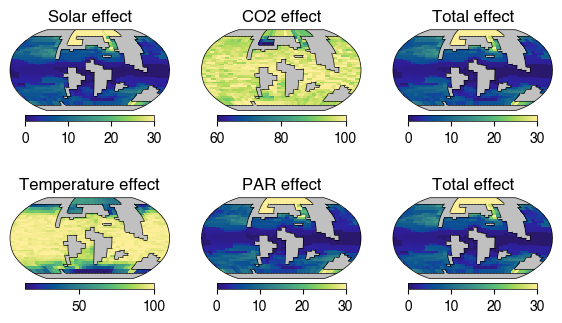

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(7, 4), subplot_kw={'projection': ccrs.Robinson()})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
from cmap import Colormap

cmap = Colormap( 'cmocean:haline').to_mpl()

data = [solar_effect, co2_effect, total_effect, par_effect, temp_effect,total_effect]
title = ['Solar effect', 'CO2 effect', 'Total effect', 'Temperature effect', 'PAR effect', 'Total effect']
vmaxs = [0.3,1.0, 0.3, 1.0, 0.3, 0.3]
for i, ax in enumerate(axs.flat):
    extinction_rate = data[i].isel(time=-1)/data[i].isel(time=0)*100
    extinction_rate.plot(ax=ax, cmap=cmap, colorbar=True, outline=True, vmax=vmaxs[i]*100)
    ax.set_title(title[i])

fig.savefig("../output/extinction_driver.png", dpi=300, bbox_inches='tight')

In [54]:
extinction_rate[-1]

<xarray.DataArray (lon: 36)> Size: 288B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    time     float64 8B 199.5
  * lon      (lon) float64 288B -175.0 -165.0 -155.0 ... 155.0 165.0 175.0
    lat      float64 8B 76.46